# Wikipedia Pageviews Analysis

Explore patterns, summary statistics, and trends in Wikipedia pageview data.

## Setup

In [ ]:
import json
import os
import sys
from pathlib import Path
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path for shared imports
sys.path.insert(0, str(Path('../').resolve()))
from shared.wikipedia.filters import is_content

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [15]:
# Load all JSON files from data/
DATA_DIR = Path('../data')

def load_pageviews(data_dir: Path) -> pd.DataFrame:
    """Load all pageview JSON files into a single DataFrame."""
    records = []
    for f in sorted(data_dir.glob('pageviews_*.json')):
        with open(f) as fp:
            records.extend(json.load(fp))
    
    df = pd.DataFrame(records)
    df['date'] = pd.to_datetime(df['date'])
    return df

df = load_pageviews(DATA_DIR)
print(f"Loaded {len(df):,} records from {df['date'].nunique()} days")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
df.head()

Loaded 152,991 records from 153 days
Date range: 2025-01-01 to 2026-02-01


,article,views,rank,date
0,Main_Page,4542992,1,2025-01-01
1,Special:Search,1481275,2,2025-01-01
2,Wikipedia:Featured_pictures,540312,3,2025-01-01
3,Squid_Game_season_2,421527,4,2025-01-01
4,Sophie_Ellis-Bextor,262150,5,2025-01-01


## Filter Content Pages

Exclude special pages (Main_Page, Special:*, User:*, etc.) to focus on actual articles.

In [ ]:
# Use shared filtering logic from shared.wikipedia.filters
# is_content() was imported above and filters out:
# - Main_Page
# - Special:*, User:*, Wikipedia:*, Template:*, etc.
# - Pages with _talk: in the name

df['is_content'] = df['article'].apply(is_content)
content = df[df['is_content']].copy()

print(f"Content pages: {len(content):,} ({100*len(content)/len(df):.1f}%)")
print(f"Filtered out: {len(df) - len(content):,} non-content records")

## Summary Statistics

In [17]:
# Daily totals
daily = content.groupby('date').agg(
    total_views=('views', 'sum'),
    unique_articles=('article', 'nunique'),
    avg_views=('views', 'mean'),
    max_views=('views', 'max')
).round(0)

print("Daily Statistics:")
daily.describe().round(0)

Daily Statistics:


,total_views,unique_articles,avg_views,max_views
count,153.0,153.0,153.0,153.0
mean,23529011.0,987.0,23843.0,908659.0
std,3672240.0,2.0,3704.0,922414.0
min,17927378.0,982.0,18145.0,223326.0
25%,21023912.0,985.0,21309.0,386721.0
50%,22713826.0,987.0,23013.0,616790.0
75%,25293474.0,988.0,25601.0,954670.0
max,38721484.0,992.0,39231.0,7791897.0


In [18]:
# Top articles by total views
top_overall = content.groupby('article')['views'].sum().sort_values(ascending=False)

print("Top 20 Articles (by total views across all days):")
top_overall.head(20)

Top 20 Articles (by total views across all days):


article
1989_Tiananmen_Square_protests_and_massacre    39419349
.xxx                                           31216666
Google_Chrome                                  30128280
Ed_Gein                                        26398900
Dhurandhar                                     17607675
Deaths_in_2025                                 17083334
ChatGPT                                        16625059
Donald_Trump                                   14507162
Zohran_Mamdani                                 13188431
Rob_Reiner                                     13151870
Stranger_Things                                10016467
Avatar:_Fire_and_Ash                            9943287
Diane_Keaton                                    9942485
Stranger_Things_season_5                        9219562
Instagram                                       8960710
Bruce_Lee                                       8923626
Pluribus_(TV_series)                            8781250
One_Battle_After_Another                

## Trends Over Time

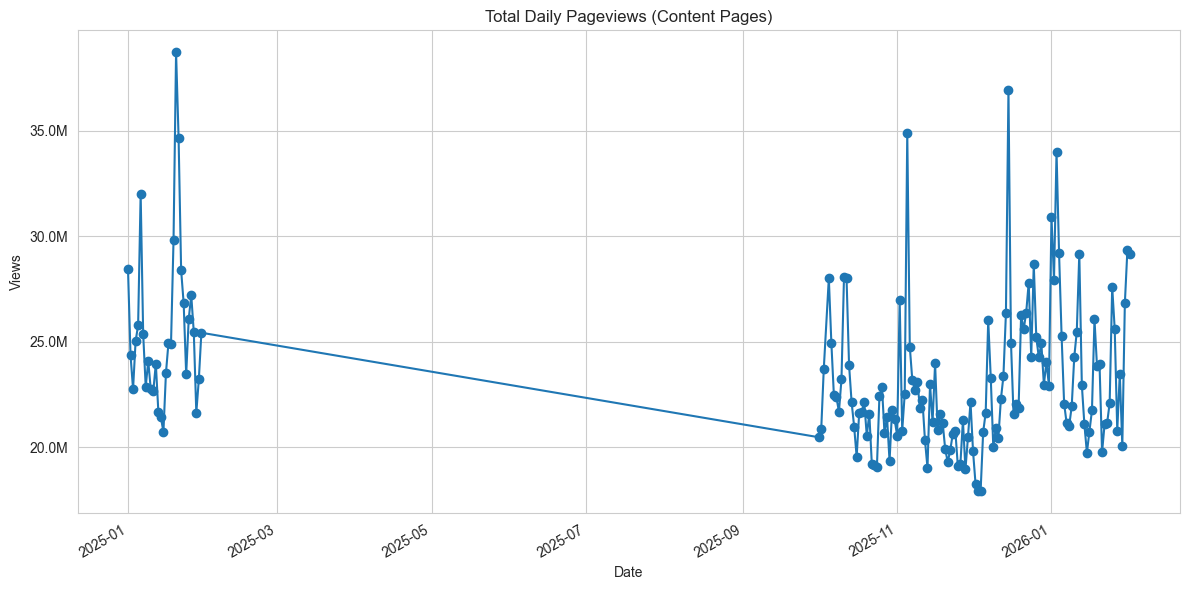

In [19]:
# Total daily views
fig, ax = plt.subplots()
daily['total_views'].plot(ax=ax, marker='o')
ax.set_title('Total Daily Pageviews (Content Pages)')
ax.set_xlabel('Date')
ax.set_ylabel('Views')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
plt.tight_layout()

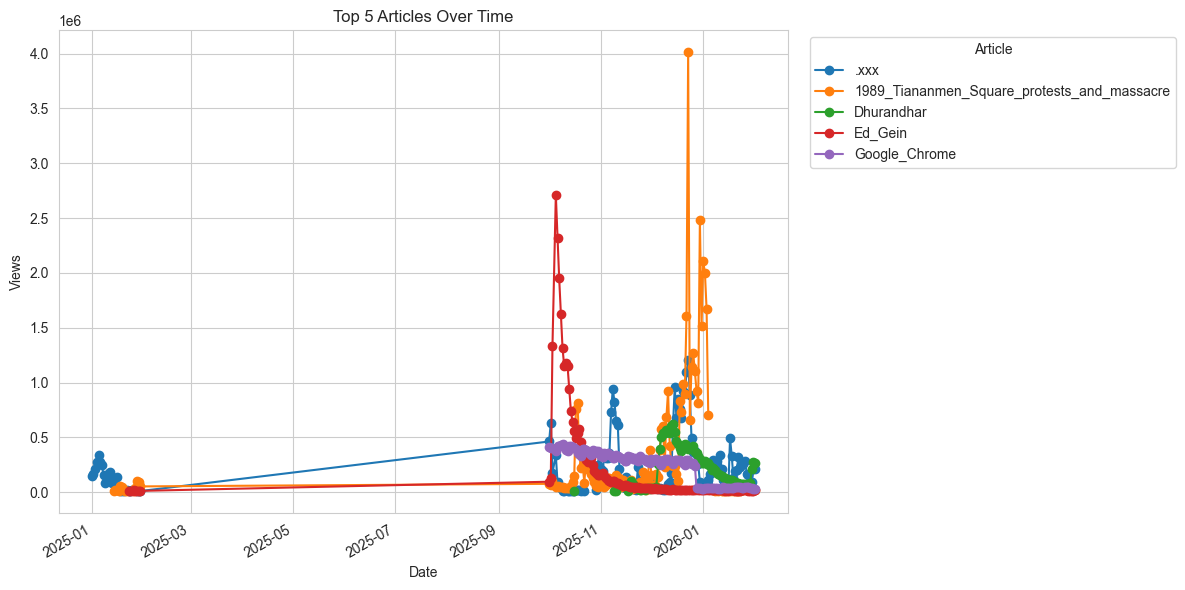

In [20]:
# Track top 5 articles over time
top5 = top_overall.head(5).index.tolist()
top5_daily = content[content['article'].isin(top5)].pivot(
    index='date', columns='article', values='views'
)

fig, ax = plt.subplots()
top5_daily.plot(ax=ax, marker='o')
ax.set_title('Top 5 Articles Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Views')
ax.legend(title='Article', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

## Interesting Patterns

In [21]:
# Find articles with biggest day-over-day spikes
# (articles that suddenly became popular)

def find_spikes(df, min_views=50000, min_ratio=3.0):
    """Find articles with sudden popularity spikes."""
    pivoted = df.pivot(index='date', columns='article', values='views').fillna(0)
    
    spikes = []
    for article in pivoted.columns:
        series = pivoted[article]
        for i in range(1, len(series)):
            prev = series.iloc[i-1]
            curr = series.iloc[i]
            if prev > 0 and curr >= min_views:
                ratio = curr / prev
                if ratio >= min_ratio:
                    spikes.append({
                        'article': article,
                        'date': series.index[i],
                        'views': int(curr),
                        'prev_views': int(prev),
                        'spike_ratio': round(ratio, 1)
                    })
    
    return pd.DataFrame(spikes).sort_values('spike_ratio', ascending=False)

spikes = find_spikes(content)
print(f"Found {len(spikes)} spike events")
spikes.head(15)

Found 1190 spike events


,article,date,views,prev_views,spike_ratio
331,Dharmendra,2025-11-24,1222914,12043,101.5
154,Aubrey_Plaza,2025-01-04,605176,10349,58.5
0,.xxx,2025-10-01,462588,10566,43.8
1117,UPS_Airlines_Flight_2976,2025-11-05,395362,10030,39.4
1089,Trey_Yesavage,2025-10-30,562310,14346,39.2
616,Lamine_Yamal,2025-10-05,452700,11642,38.9
570,Justin_Trudeau,2025-01-06,496253,12966,38.3
706,Marjorie_Taylor_Greene,2025-11-22,324661,8660,37.5
520,Jayden_Daniels,2025-01-19,430832,12630,34.1
228,Cam_Skattebo,2025-10-10,339707,10246,33.2


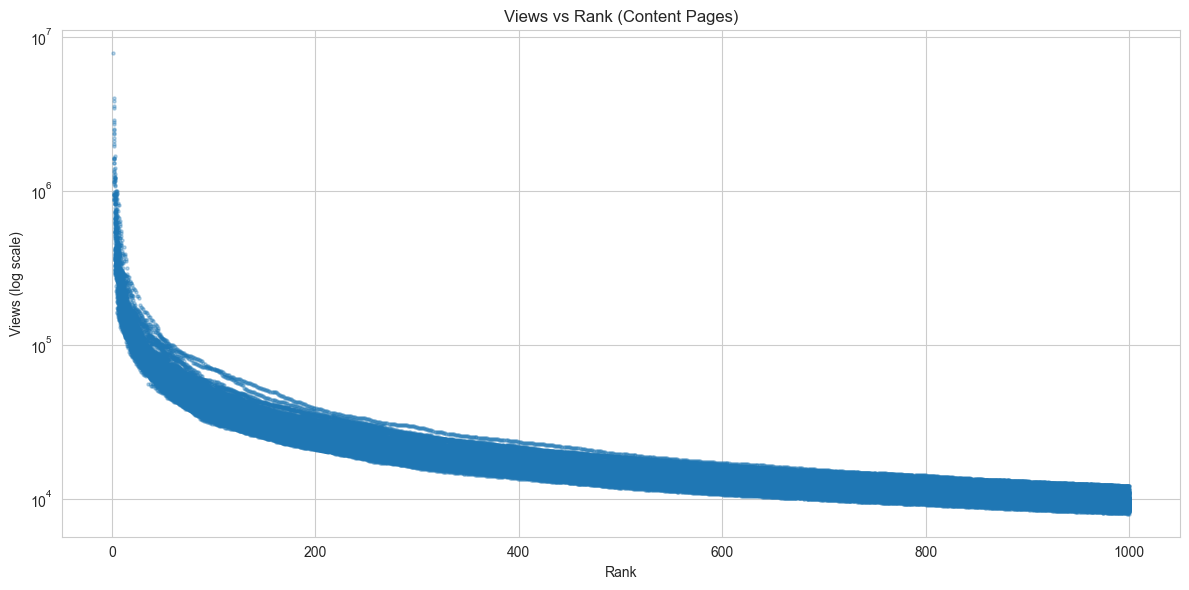

In [22]:
# Views vs Rank distribution (log scale)
fig, ax = plt.subplots()
ax.scatter(content['rank'], content['views'], alpha=0.3, s=5)
ax.set_yscale('log')
ax.set_title('Views vs Rank (Content Pages)')
ax.set_xlabel('Rank')
ax.set_ylabel('Views (log scale)')
plt.tight_layout()

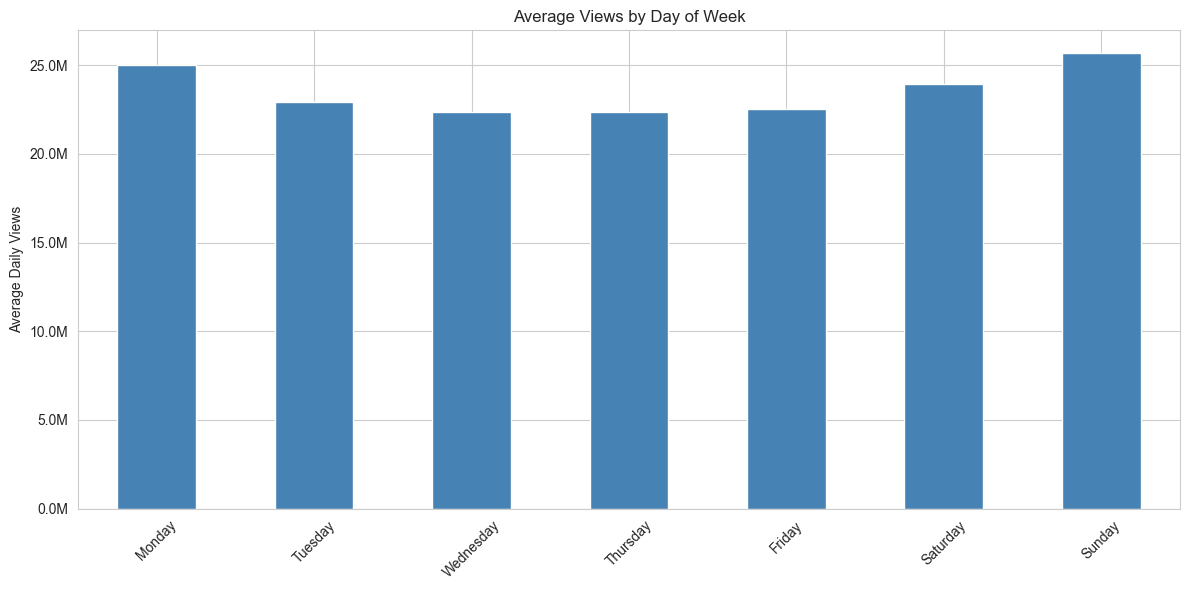

In [23]:
# Day of week patterns
daily['day_of_week'] = daily.index.day_name()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots()
daily.groupby('day_of_week')['total_views'].mean().reindex(dow_order).plot(
    kind='bar', ax=ax, color='steelblue'
)
ax.set_title('Average Views by Day of Week')
ax.set_xlabel('')
ax.set_ylabel('Average Daily Views')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
plt.xticks(rotation=45)
plt.tight_layout()

## Consistency Analysis

Which articles consistently rank high vs. which are one-hit wonders?

In [24]:
# Articles that appear in top 100 most consistently
n_days = content['date'].nunique()
top100_per_day = content[content['rank'] <= 100]

consistency = top100_per_day.groupby('article').agg(
    days_in_top100=('date', 'nunique'),
    avg_rank=('rank', 'mean'),
    avg_views=('views', 'mean'),
    total_views=('views', 'sum')
).sort_values('days_in_top100', ascending=False)

consistency['pct_days'] = (100 * consistency['days_in_top100'] / n_days).round(1)

print(f"Most Consistent Top-100 Articles ({n_days} days):")
consistency.head(20)

Most Consistent Top-100 Articles (153 days):


,days_in_top100,avg_rank,avg_views,total_views,pct_days
article,,,,,
ChatGPT,148,27.364865,110925.256757,16416938,96.7
Donald_Trump,141,51.758865,99464.687943,14024521,92.2
YouTube,131,69.137405,50528.106870,6619182,85.6
Deaths_in_2025,122,16.786885,138827.852459,16936998,79.7
Instagram,117,69.666667,64377.675214,7532188,76.5
.xxx,107,19.429907,285234.336449,30520074,69.9
Google_Chrome,103,18.194175,285393.174757,29395497,67.3
1989_Tiananmen_Square_protests_and_massacre,94,26.127660,411147.351064,38647851,61.4
One_Battle_After_Another,89,45.235955,81627.505618,7264848,58.2


In [25]:
# One-hit wonders: high views but only appeared once in top 100
one_hit = consistency[
    (consistency['days_in_top100'] == 1) & 
    (consistency['total_views'] > 100000)
].sort_values('total_views', ascending=False)

print(f"One-Hit Wonders (top 100 for only 1 day, >100k views):")
one_hit.head(15)

One-Hit Wonders (top 100 for only 1 day, >100k views):


,days_in_top100,avg_rank,avg_views,total_views,pct_days
article,,,,,
List_of_most-visited_websites,1,2.0,1624950.0,1624950,0.7
2025_Potomac_River_mid-air_collision,1,3.0,880515.0,880515,0.7
Marianne_Faithfull,1,4.0,422416.0,422416,0.7
E-Government_in_Saudi_Arabia,1,5.0,389259.0,389259,0.7
Jaxon_Smith-Njigba,1,7.0,306844.0,306844,0.7
Aunt_Jemima,1,4.0,295492.0,295492,0.7
Amy_Klobuchar,1,16.0,274203.0,274203,0.7
Election_Commission_of_India,1,5.0,260337.0,260337,0.7
Diana_Ross,1,9.0,250006.0,250006,0.7
